In [1]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from keras.layers import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

2022-12-07 00:35:03.821830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def display_grid(data, path, w =10, h =10, columns = 4, rows = 5):
    fig=plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        file = data[i]
        file = os.path.join(path, file)
        img = Image.open(file)
        fig.add_subplot(rows, columns, i)
        imshow(img)
    plt.show()

def plot_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')



    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

def get_best_epcoh(history):
    valid_acc = history.history['val_acc']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

## Class Swift

In [3]:
base_dir = '/Users/vlasov/PycharmProjects/Identify-a-Car-Model-with-Deep-Learning/kaggle/'
train_swift = os.listdir(os.path.join(base_dir, 'train/swift') )
val_swift  = os.listdir(os.path.join(base_dir, 'validation/swift') )
test_swift  =  os.listdir(os.path.join(base_dir, 'test/swift') )
print('Instances for Class Swift: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Swift: Train 1200, Validation 400 Test 400


In [4]:
#Sanity checks: no overlaping bteween train test and validation sets
val_train = [x for x in val_swift if x in train_swift]
test_train = [x for x in test_swift if x in train_swift]
val_test =  [x for x in test_swift if x in val_swift]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

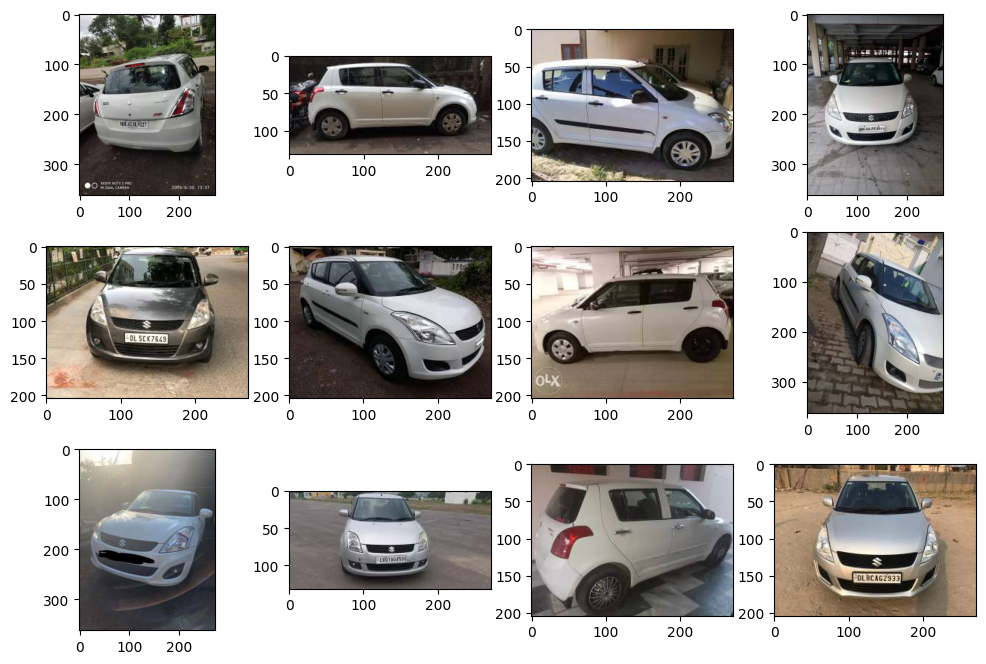

In [5]:
display_grid(data = train_swift, path = os.path.join(base_dir, 'train/swift'), w =10, h =10, columns = 4, rows = 3)

## Class Wagonr

In [6]:
train_wr = os.listdir(os.path.join(base_dir, 'train/wagonr') )
val_wr  = os.listdir(os.path.join(base_dir, 'validation/wagonr') )
test_wr  =  os.listdir(os.path.join(base_dir, 'test/wagonr') )
print('Instances for Class Wagonr: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Wagonr: Train 1200, Validation 400 Test 400


In [7]:
#Sanity checks: no overlaping bteween train test and validation sets
val_train = [x for x in val_wr if x in train_wr]
test_train = [x for x in test_wr if x in train_wr]
val_test =  [x for x in test_wr if x in val_wr]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

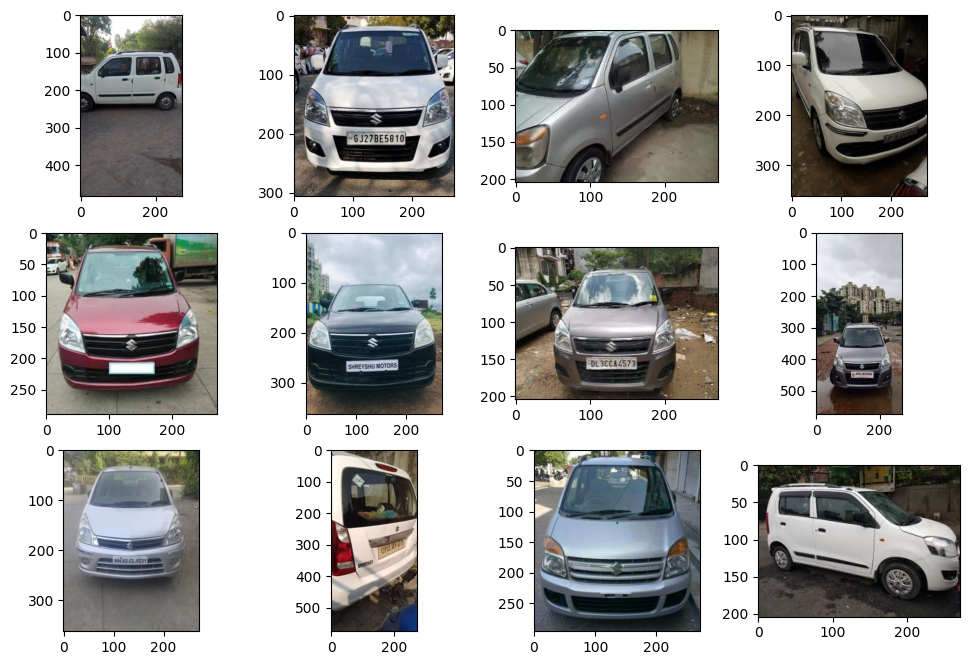

In [8]:
display_grid(data = train_wr, path = os.path.join(base_dir, 'train/wagonr'), w =10, h =10, columns = 4, rows = 3)

## Build CNN Model With Drop out and BN

In [9]:
def build_cnn(display_summary =False):
    model = models.Sequential()
    model.add( layers.Conv2D(32, (3,3),  input_shape = (150, 150, 3)) )
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(64, (3,3)) )
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(128, (3,3)) )
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(128, (3,3)) )
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(512))
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(1, activation= 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizers.Adagrad(),
                  metrics = ['acc']
                  )
    if display_summary:
       model.summary()
    return model

## Data Preprocessing

### Data Augumenation data example

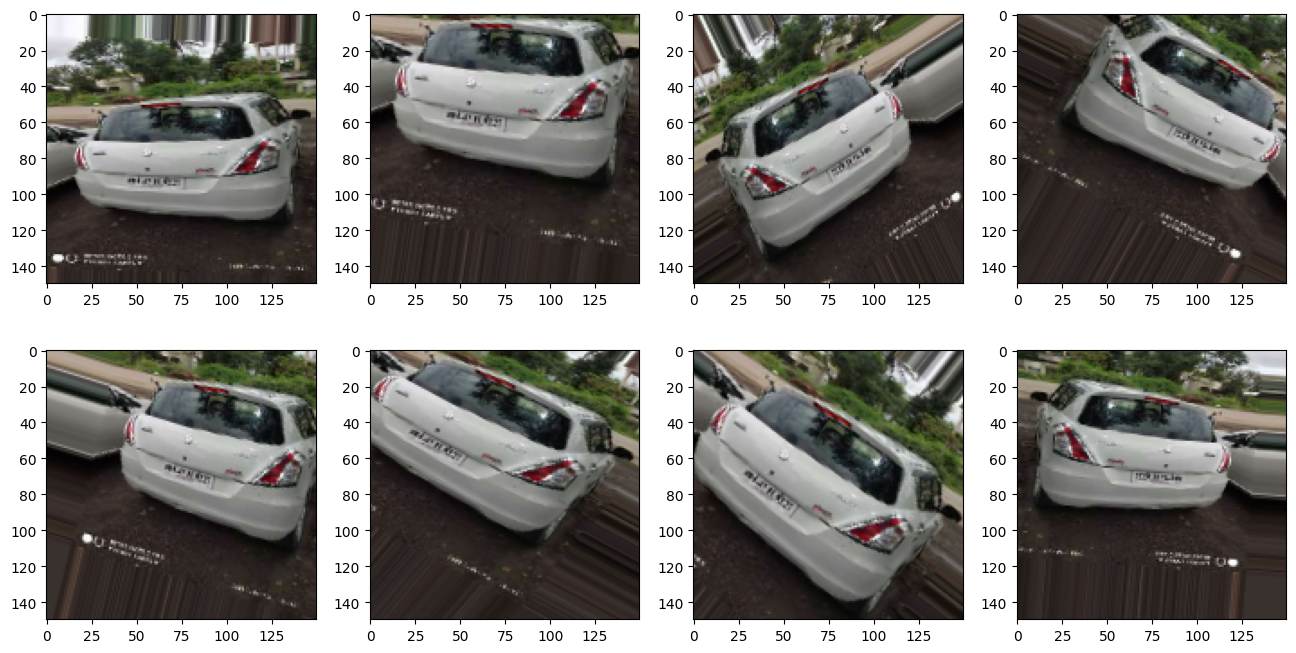

In [10]:
datagen = ImageDataGenerator( rotation_range= 40,
                              width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
#                              fill_mode = 'nearest'
                            )

path = os.path.join(base_dir, 'train/swift')
file = train_swift[1]
image_path = os.path.join(path, file )

img = image.load_img(image_path, target_size = (150,150))
x= image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i =0
fig=plt.figure(figsize=(16, 8))
for batch in datagen.flow(x, batch_size = 1):
    i +=  1
    fig.add_subplot(2, 4, i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))

    if i % 8 == 0:
        break


## Data Preprocessing with Augumentation

In [11]:

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation' )


train_datagen = ImageDataGenerator(
                                  rescale = 1./255,
                                  rotation_range= 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2  ,
                                  horizontal_flip = True,
                                   )
test_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(
                                                   train_dir,
                                                   target_size = (150,150), #Resize images to 150 X 150
                                                   batch_size  = 20,
                                                   class_mode = 'binary'
                                                   )
validation_generator = test_datagen.flow_from_directory(
                                                   validation_dir,
                                                   target_size = (150,150), #Resize images to 150 X 150
                                                   batch_size  = 20,
                                                   class_mode = 'binary'
                                                   )

for data_batch, labels_batch, in train_generator:
    print('Data Batch shape:', data_batch.shape)
    print('Labels Batch shape:', labels_batch.shape)
    break

Found 2400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Data Batch shape: (20, 150, 150, 3)
Labels Batch shape: (20,)


### Fit Model

In [12]:
model = build_cnn(display_summary = True)


2022-12-07 00:35:20.560537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 64)        0

In [13]:
%%time
callback_list = [#save best model
                 ModelCheckpoint(filepath= 'cars_keras_data_aug_drop_bn_adagrad.h5', monitor= 'val_acc', save_best_only= True),

                 ]

history = model.fit_generator(
                            train_generator,
                            steps_per_epoch = 120,  # = num_train_images/batch size(2400/20)
                            epochs = 50,
                            validation_data = validation_generator,
                            callbacks = callback_list,
                            validation_steps = 40  # = num_valid_images/batch_size
                             )


<timed exec>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
120/120 [==============================] - 146s 1s/step - loss: 0.8331 - acc: 0.5367 - val_loss: 0.7161 - val_acc: 0.5000
Epoch 2/50
120/120 [==============================] - 203s 2s/step - loss: 0.8118 - acc: 0.5479 - val_loss: 0.6966 - val_acc: 0.5138
Epoch 3/50
120/120 [==============================] - 233s 2s/step - loss: 0.7585 - acc: 0.5825 - val_loss: 0.6558 - val_acc: 0.6175
Epoch 4/50
120/120 [==============================] - 239s 2s/step - loss: 0.7392 - acc: 0.5921 - val_loss: 0.6231 - val_acc: 0.6587
Epoch 5/50
120/120 [==============================] - 234s 2s/step - loss: 0.7120 - acc: 0.6158 - val_loss: 0.5958 - val_acc: 0.6913
Epoch 6/50
120/120 [==============================] - 227s 2s/step - loss: 0.7068 - acc: 0.6033 - val_loss: 0.6378 - val_acc: 0.6513
Epoch 7/50
120/120 [==============================] - 325s 3s/step - loss: 0.6855 - acc: 0.6321 - val_loss: 0.5855 - val_acc: 0.6988
Epoch 8/50
120/120 [==============================] - 361s 3s/step - 

### Train Vs Validation Accuracy/Loss

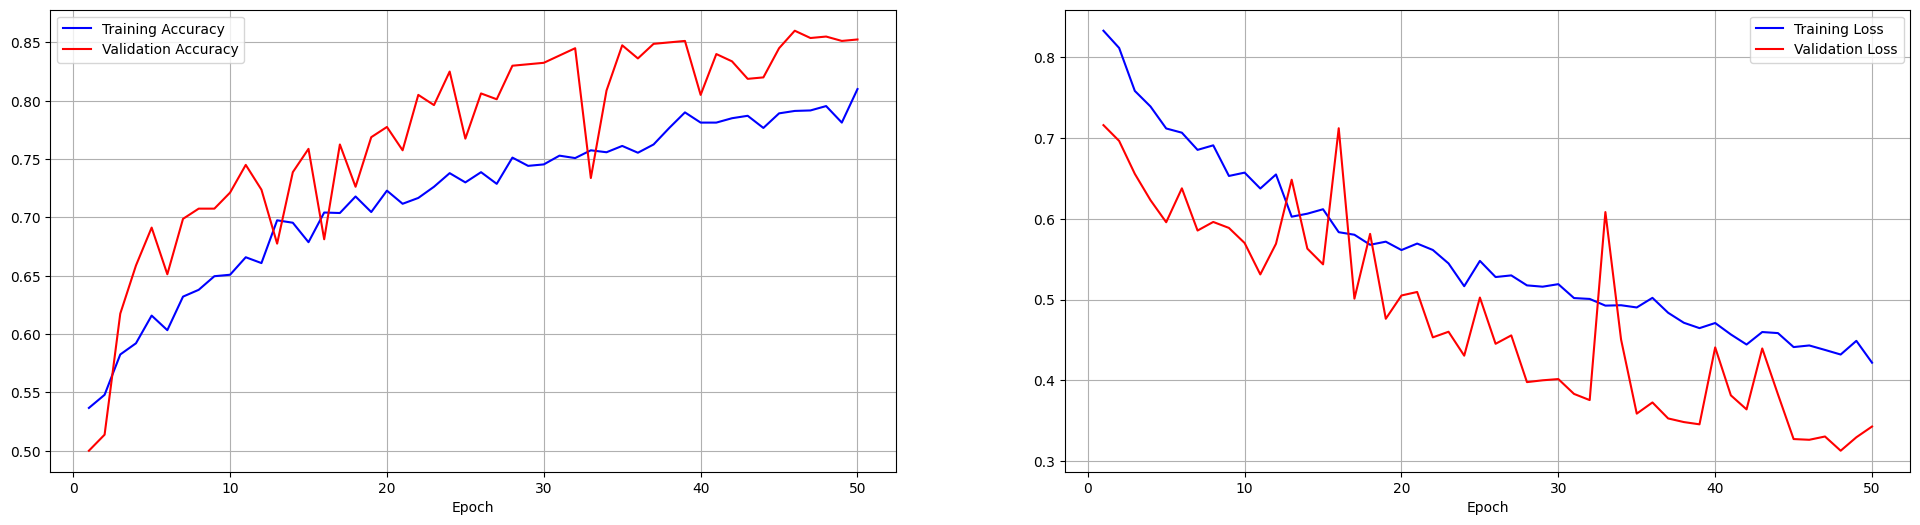

Best Validation Accuracy Score 0.86000, is for epoch 46


In [14]:
plot_results(history)
best_epoch =get_best_epcoh(history)
